# Stock Forecast and Quantitative Investment Analysis--Netflix

##### VVVDDPP Group Project for BUDT758B
##### Hui He, Kelsey Shi, Xiaoya Wang, Diana Wang, Qing Yan, Zhuofan Zhang
##### May 2020

Our group conducts numerical analysis on the leading enterprises of both technology Industry, entertainment industry and pharmaceutical industry. To be more specific, we analyze the stock behavior of Apple, Netflix and Pfizer. Numerical analysis based on historical stock data is also known as technical analysis. Technical analysis can predict the trend of prices and can further decide on investment strategyby by studying the past financial market information. It assumes that history will repeat itself. As long as we mine historical data for patterns that repeat themselves, we can use this pattern to design profitable strategies. Therefore, we conduct stock forecast by technical analysis and try to give some suggestions on quantitative investment.

## 1. Data Acquisiton and Visualization

* There are a lot of public interfaces and softwares on the web to get stock data, such as AlphaVantage, Google Finance in Google Sheets, IEX Cloud and so on. Here we use Yahoo Finance to get the stock data we need. Yahoo Finance provides access to many years of daily OHLC price data. And it’s free and reliable. Here we extract 10 years' stock data to conduct the analysis.

In [210]:
#!pip install yfinance
#!pip install --upgrade mplfinance
#!pip install TA-Lib
#!pip install yahoofinancials
#!pip install yfinance --upgrade --no-cache-dir
#!pip install fix-yahoo-finance
#!pip install iexfinance
#!pip install bs4
#!pip install selenium
#!pip install chromedriver_binary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import yfinance as yf
import mplfinance as mpf
from bs4 import BeautifulSoup
import requests
import re
from selenium import webdriver
import chromedriver_binary
import warnings 
warnings.filterwarnings('ignore')
import datetime as dt
import math

### 1.1 Data Extraction:
* scrapping financial data from yahoo finance
* download stock market price data from yahoo finance API

In [2]:
#download stock data from yahoo finance
stock_df=yf.download("NFLX",start="2010-01-01",end="2019-12-31")

[*********************100%***********************]  1 of 1 completed


### 1.2 Data Preparation and Visualization
* Plot `Candlestick Chart` to see the trend
* Capture and Visualize `Candlestick Chart` Features: `Morning Star`,`Evening Star`,`Dark Cloud`
* Calculate Technical Indicators: `Momentum`,`SMA(Simple Moving Average)`,`EMA(Exponential Moving Average)`,`Bollinger Bands`
* Create a list for newly created features

### 1.2.1 Candlestick Chart

#### Only take the data from 12/2019 to plot and observe the trend.

In [3]:
plotdata=stock_df[['Open','High','Low','Close','Volume']]
plotdata=plotdata.iloc[plotdata.index >= '20191201', :]


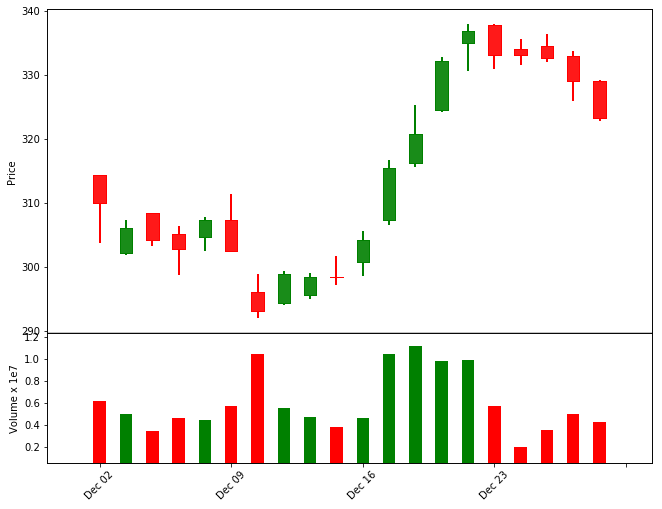

In [4]:
#Candlestick chart
mc = mpf.make_marketcolors(up='g',down='r',
                           edge='inherit',
                           wick='in',
                           volume='i')
s=mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotdata,type='candle',volume=True,style=s,figratio=(12,9))

#### Capture the Feature of the Candlestick Chart
* Morning Star: Signal for price going up when it outputs 100
* Evening Star: Signal for price going down when it outputs -100
* Dark Cloud Cover: Signal for price going down when it outputs -100

#### 1. Morning Star

Morning Star
Date
2018-08-20    100
2018-10-09    100
2019-03-11    100
2019-04-16    100
dtype: int32


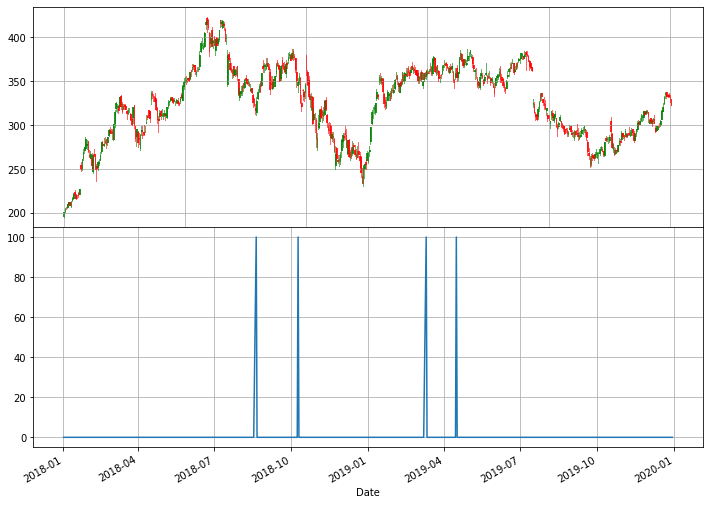

In [5]:
#Morning Star for price for recent 2 years 
df_sample=stock_df.iloc[stock_df.index>='20180101',:]
fig,(ax1,ax2)=plt.subplots(2,1,sharex=False,figsize=(12,9))

from mplfinance.original_flavor import candlestick2_ochl
candlestick2_ochl(ax1, df_sample['Open'], df_sample['Close'], df_sample['High'], df_sample['Low'],
                  width=0.5, colorup='g', colordown='r',
                  alpha=0.6)
ax1.grid(True)

result = talib.CDLMORNINGSTAR(df_sample['Open'], df_sample['High'], df_sample['Low'], df_sample['Close'], penetration=0)
result.plot(ax=ax2)

ax2.grid(True)
plt.subplots_adjust(hspace=0) 
#return Morning Star Points
result_positive = result.loc[result == 100]
print('Morning Star')
print(result_positive)


#### 2. Evening Star

Evening Star
Date
2017-03-21   -100
dtype: int32


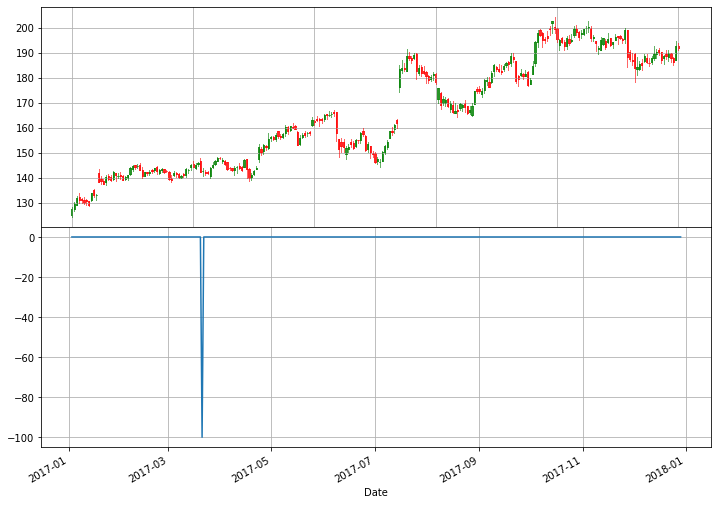

In [6]:
#Evening Star for recent 2 years

df2017 = stock_df.iloc[stock_df.index < '20180101', :]
df2017 = df2017.iloc[df2017.index >= '20170101', :]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, figsize=(12, 9))

from mplfinance.original_flavor import candlestick2_ochl
candlestick2_ochl(ax, df2017['Open'], df2017['Close'], df2017['High'], df2017['Low'],
                  width=0.5, colorup='g', colordown='r',
                  alpha=0.6)
ax.grid(True)

result = talib.CDLEVENINGSTAR(df2017['Open'], df2017['High'], df2017['Low'], df2017['Close'], penetration=0)
result.plot(ax=ax2)

ax2.grid(True)
plt.subplots_adjust(hspace=0)
result_negative = result.loc[result == -100]
print('Evening Star')
print(result_negative)

#### 3. Dark Cloud Cover

Dark Cloud
Date
2018-05-22   -100
2018-07-03   -100
2018-08-03   -100
2018-08-23   -100
2018-09-13   -100
2018-09-19   -100
dtype: int32


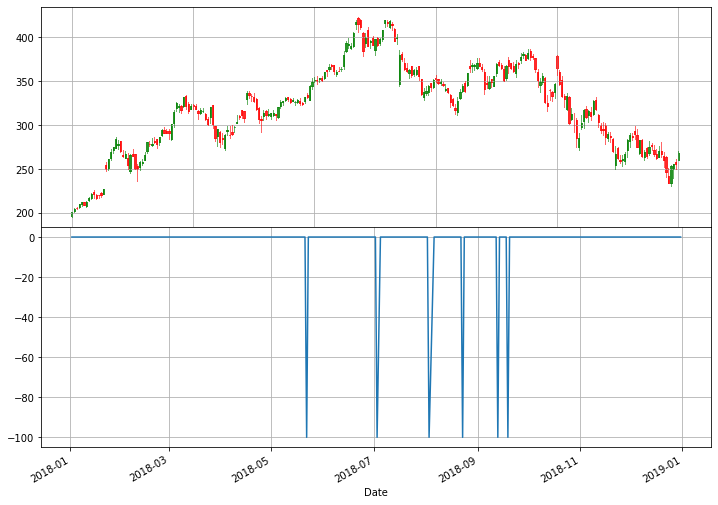

In [7]:
#Dark Cloud Cover for recent two years
df2018 = stock_df.iloc[stock_df.index >= '20180101', :]
df2018 = df2018.iloc[df2018.index < '20190101', :]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, figsize=(12, 9))

from mplfinance.original_flavor import candlestick2_ochl
candlestick2_ochl(ax, df2018['Open'], df2018['Close'], df2018['High'], df2018['Low'],
                  width=0.5, colorup='g', colordown='r',
                  alpha=0.6)
ax.grid(True)  

result = talib.CDLDARKCLOUDCOVER(df2018['Open'], df2018['High'], df2018['Low'], df2018['Close'], penetration=0)
result.plot(ax=ax2)

ax2.grid(True)
plt.subplots_adjust(hspace=0)  
result_negative = result.loc[result == -100]
print('Dark Cloud')
print(result_negative)

In [8]:
#store all the technical indicators in a list
ta_features=['Momentum','SMA','EMA','Upperband','Middleband','Lowerband']

### 1.2.2 Calculate and Visualize the Technical Indicators

* Momentum: the difference between closing prices in n days.
* Simple Moving Average: an arithmetic moving average calculated by adding recent prices and then dividing that by the number of time periods in the calculation average.
* Exponential Moving Average: an arithmetic moving average that places a greater weight and significance on the most recent data points. 
* Bollinger Bands:  a technical analysis tool defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the security's price, but can be adjusted to user preferences. 

In [9]:
#Momentum
stock_df['Momentum']=talib.MOM(stock_df['Close'],timeperiod=1)
#SMA
timeperiod=30
stock_df['SMA']=talib.SMA(stock_df['Close'],timeperiod=timeperiod)
#EMA
stock_df['EMA'] = talib.EMA(stock_df['Close'], timeperiod=timeperiod)
#Bollinger Bands
timeperiod = 5 #set time window as 5
nbdevup = 2  #band width up and down both as 2 std
nbdevdn = 2 
stock_df['Upperband'], stock_df['Middleband'], stock_df['Lowerband'] = talib.BBANDS(stock_df['Close'], timeperiod=timeperiod, nbdevup=nbdevup, nbdevdn=nbdevdn)


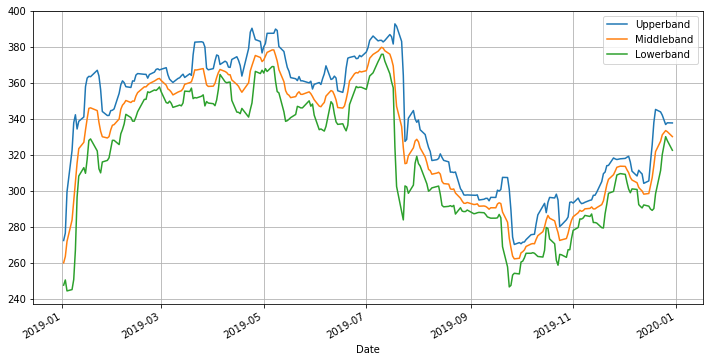

In [10]:
#plot Bollinger Bands for observation
stock_df_sample = stock_df.iloc[stock_df.index >= '20190101', :]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
stock_df_sample[['Upperband', 'Middleband', 'Lowerband']].plot(ax=ax)
ax.grid(True) 
ax.legend();


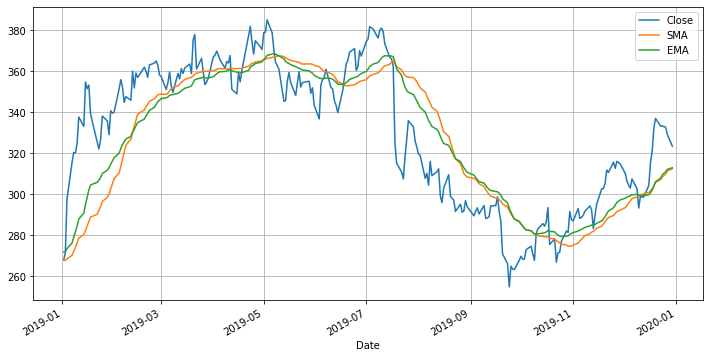

In [11]:
#use data for 2019 to observe the difference between 'SMA' and 'EMA'
df_sample = stock_df.iloc[stock_df.index >= '20190101', :]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
df_sample[['Close', 'SMA', 'EMA']].plot(ax=ax)
ax.grid(True)
ax.legend();

### 1.2.3 Calculate Financial Indicators for the Stock

* netIncome: Net income, the amount an individual earns after subtracting taxes and other deductions from gross income.
* equity: ownership of assets that may have debts or other liabilities attached to them. 
* ROE: return on equity,  measures how many dollars of profit are generated for each dollar of shareholder’s equity. 
* pre_close
* pct_chg: percent change for eachday's stock price.

In [12]:
#define a function to scrap financial statement for the stock from yahoo finance
def scraper_to_statement(link):
    
    headers = []
    temp_list = []
    final = []
    index = 0
    
    #pull data from link
    page_response = requests.get(link, timeout=1000)
    #structure raw data for parsing
    page_content = BeautifulSoup(page_response.content)
    #filter for items we want
    features = page_content.find_all('div',class_='D(tbr)')
    
    #create headers
    for item in features[0].find_all('div', class_='D(ib)'):
        headers.append(item.text)
        
    #statement contents
    while index <= len(features)-1:
        #filter for each line of the statement
        temp = features[index].find_all('div', class_='D(tbc)')
        for line in temp:
            #each item adding to a temporary list
            temp_list.append(line.text)
        #temp_list added to final list
        final.append(temp_list)
        #clear temp_list
        temp_list = []
        index+=1
    
    df = pd.DataFrame(final[1:])
    df.columns = headers
    
    return df

In [13]:
is_link = 'https://finance.yahoo.com/quote/NFLX/financials?p=NFLX'
bs_link = 'https://finance.yahoo.com/quote/NFLX/balance-sheet?p=NFLX'
cf_link = 'https://finance.yahoo.com/quote/NFLX/cash-flow?p=NFLX'

In [14]:
income_statement=scraper_to_statement(is_link)
balance_sheet=scraper_to_statement(bs_link)
cash_flow=scraper_to_statement(cf_link)

In [15]:
#get netIncome data
netIncome=income_statement.iloc[13]
netIncome=netIncome.drop(['ttm','Breakdown']).str.replace(',','').astype('float')
netIncome

12/31/2019    1866916.0
12/31/2018    1211242.0
12/31/2017     558929.0
12/31/2016     186678.0
Name: 13, dtype: float64

In [16]:
#get equity data
equity=balance_sheet.iloc[35].drop('Breakdown').str.replace(',','').astype('float')
equity

12/31/2019    7582157.0
12/31/2018    5238765.0
12/31/2017    3581956.0
12/31/2016    2679800.0
Name: 35, dtype: float64

In [17]:
#calculate ROE(Return of Equity)
ROE=netIncome/equity
ROE

12/31/2019    0.246225
12/31/2018    0.231208
12/31/2017    0.156040
12/31/2016    0.069661
dtype: float64

In [18]:
#create a column for the year of the stock price 
stock_df.reset_index(inplace=True)
stock_df['year']=stock_df['Date'].astype('str').apply(lambda x:x[:4]).tolist()


In [19]:
#append ROE data for each observation
stock_df['ROE']='NaN'
stock_df['ROE'][(stock_df['year']>='2010')&(stock_df['year']<'2017')]=ROE.iloc[3]
stock_df['ROE'][stock_df['year']=='2017']=ROE.iloc[2]
stock_df['ROE'][stock_df['year']=='2018']=ROE.iloc[1]
stock_df['ROE'][stock_df['year']>'2019']=ROE.iloc[0]

In [20]:
#create the 'pre_close' data
start=yf.download("NFLX",start="2009-12-25",end="2009-12-31")['Close'][2]
stock_df['pre_close']='NaN'
stock_df['pre_close'].iloc[0]=start


[*********************100%***********************]  1 of 1 completed


In [21]:
for i in range(1,stock_df.shape[0]):
    stock_df['pre_close'].iloc[i]=stock_df['Close'].iloc[i-1]

In [22]:
#calculate percent change for eachday's stock price
stock_df['pct_chg']=(stock_df['Close']-stock_df['pre_close'])/stock_df['pre_close']

## 2. Data Preprocessing

### 2.1 Impute Null Values

In [23]:
#impute the null data
stock_df=stock_df.fillna(method='ffill')
stock_df.dropna(inplace=True)
stock_df.shape

(2486, 17)

## 2.2 Standard Scale data

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
mom_scaled = MinMaxScaler().fit_transform(stock_df[['Momentum']])
mom_scaled = StandardScaler().fit_transform(stock_df[['Momentum']])

## 2.3 Feature Transformation

* New feature are created by appling nonlinear function to old features. Here we use PolynomialFeatures in sklearn.preprocessing to create a new feature: log(1+x) on momentum.

In [25]:
from sklearn.preprocessing import PolynomialFeatures

In [26]:
stock_df['Mom2'] = PolynomialFeatures().fit_transform(stock_df[['Momentum']])[:,2] 


In [27]:
from numpy import log1p
from sklearn.preprocessing import FunctionTransformer
stock_df['mom_log'] = FunctionTransformer(log1p).fit_transform(stock_df[['Momentum']])
print(stock_df[['Momentum', 'mom_log']].head())

    Momentum   mom_log
29  0.240001  0.215112
30 -0.050000 -0.051293
31  0.227142  0.204688
32  0.078571  0.075637
33 -0.197143 -0.219578


## 3. Function to Use

### Funtion 1: up or down function
* We transfer the predictions into going up or down and calculate the predictions' accuracy

In [28]:
#define a function to return up and down indicators
def up_or_down(ser):
    y_class=[]
    for value in ser:
        if value>0:
            y_class.append(1)
        else:
            y_class.append(0)
    return y_class

In [29]:
# define a function to return the accuracy for up or down classification
def up_or_down_acc(pred,true_value):
    total_right=0
    for i in range(0,len(pred)):
        if pred[i]==true_value[i]:
            total_right+=1
    return(total_right/len(pred))
        

### Function 2: loss function 

* we use RMSE as our loss function to evaluate the accuracy of our model's log return predictions

In [30]:
def get_rmse(y_true, y_pred):
    '''Compute root mean squared error (RMSE)'''
    # convert the variable from numpy 
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.sqrt(((y_true - y_pred) ** 2).mean())

In [31]:
#we define a function that rolling the input data
def get_preds_rolling(df, target_col, N, pred_func, offset):
    # apply roling to a dataframe, eg.train_validation
    # target_col is our target variable column， here is log return
    # n is the time window, using t-1, t-2 ......
    pred_list = df[target_col].rolling(window = N).apply(pred_func)
    # add a NAN at the beginning of the list
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    # return the offset of our input datafrane
    return pred_list[offset:]

### Function 3: Split data function

* We split data into train,validation and test set and calculate log(return).

In [32]:
def split_data(df):
    df['Date']=df['Date'].astype('str').apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d'))
    df = df.set_index('Date', drop=False)
    df = df.sort_index()
    # count log return
    df['Close1'] = df['Close'].shift(-1)
    df['log_ret'] = np.log(df['Close1'] / df['Close']) 
    df = df.dropna()
    train = df['2010-01-01':'2017-12-31'] # use 2010 to 2017 as training data
    validation = df['2018-01-01': '2018-12-31'] # use 2018 as validation data
    train_validation = df['2010-01-01':'2018-12-31'] # train set and validation st
    test = df['2019-01-01': '2019-12-31'] # test set
    return df, train, validation, train_validation, test



## 4. Predict Log Return and Classify Stock Price's Trend based on Log Return

* Prediction on logarithm of return is more meaningful. 

* Benefits of log return: 
* Time additive: Note that the two-period log return is identical to the sum of the each period’s log return. To get the n-period log return, we can simply add the consecutive single period log returns. Conversely, notice the simple return is not time additive.
* Mathematically convenient: logs and exponents are easier to manipulate with calculus. Theoretical models tend to assume, unrealistically but conveniently, continuously compounded rates of return. For example, if LogReturn = LN(P1/P0), then EXP[LogReturn] = P1/P0. If f(y) = EXP[LogReturn] then the first derivative, f’(y) is quite wonderfully also EXP[LogReturn]. In short, d/dx EXP[x] = EXP[x].
* Approximately good: for short periods (e.g., daily), the log return approximates the discrete return anyway

### 4.1 Linear Model

* Target Variable: log(Return)

In [33]:
#! pip install arch
from statsmodels.stats.diagnostic import unitroot_adf
from arch.unitroot import ADF


In [34]:
#split train,validation and test set
df, train, validation, train_validation, test = split_data(stock_df)
    
print('Train dataset shape: %s' % str(train.shape))
print('Validation dataset shape: %s' % str(validation.shape))
print('Test dataset shape: %s' % str(test.shape))

Train dataset shape: (1693, 21)
Validation dataset shape: (142, 21)
Test dataset shape: (142, 21)


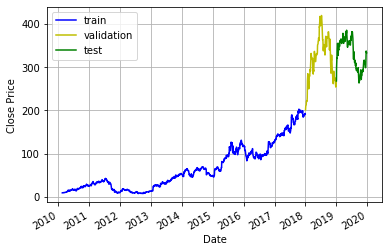

In [35]:
#see the trend in train, validation and test data
ax = train.plot(x='Date', y='Close', style='b-', grid=True)
ax = validation.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test']);
ax.set_xlabel("Date");
ax.set_ylabel('Close Price');

Text(0, 0.5, 'Close Price')

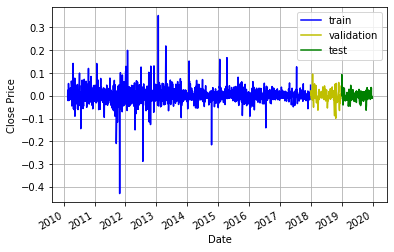

In [36]:
#ADF validation to see if the data is stable based on time series
ax = train.plot(x='Date', y='log_ret', style='b-', grid=True)
ax = validation.plot(x='Date', y='log_ret', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='log_ret', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel('Close Price')

### 4.1.1 Predict Today's log(return) based on the previous day's log(return)

In [37]:
target_col = 'log_ret'
N = 1
# defnine the prediction function 
def pred_func(x):
    return x

pred_list = train_validation[target_col].rolling(window = N).apply(pred_func)

In [38]:
# use yesterday's log_ret' as the the predicted log return
pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
train_set = train.shape[0]
y_pred = pred_list[train_set:]
y_true = validation['log_ret']

In [39]:
oneday_rmse = get_rmse(y_true, y_pred)
oneday_acc=up_or_down_acc(up_or_down(y_pred),up_or_down(y_true))
print('Results of one-day prediction')
print('RMSE: %f' % oneday_rmse)
print(f'Accuracy of predicting the stock market price for that day going up or down is {oneday_acc:.4}.')

Results of one-day prediction
RMSE: 0.030929
Accuracy of predicting the stock market price for that day going up or down is 0.5845.


### 4.1.2 Predict Today's log(return) based on N previous day's log(return)

In [40]:
# define a new predict function with mean of x
def pred_func(x):
    return np.mean(x)

Try n from 2 to 25, the RMSE is decreasing

In [41]:
validation_rmse_list = []
target_col = 'log_ret'

offset = train.shape[0]
for N in np.arange(2, 26):
    y_pred = get_preds_rolling(train_validation, target_col, N, pred_func, offset)
    y_true = validation[target_col].values
    validation_rmse_list.append(get_rmse(y_true, y_pred))

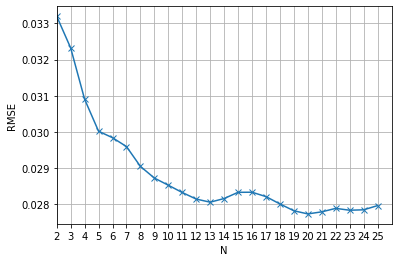

In [42]:
plt.figure()
plt.plot(np.arange(2, 26), validation_rmse_list, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 26])
plt.xticks(np.arange(2, 26));

In [44]:
N = 20

offset = train_validation.shape[0]
y_pred = get_preds_rolling(df, target_col, N, pred_func, offset)
y_true = test[target_col].values
mov_avg_rmse = get_rmse(y_true, y_pred)
nday_acc=up_or_down_acc(up_or_down(y_pred),up_or_down(y_true))
print('Results of moving average prediction')
print('RMSE: %f' % mov_avg_rmse)
print(f'Accuracy of predicting the stock market price for that day going up or down is {nday_acc:.4}.')

Results of moving average prediction
RMSE: 0.021756
Accuracy of predicting the stock market price for that day going up or down is 0.4014.


### 4.1.3 ARIMA(Autoregressive Integrated Moving Average model)

* Autoregressive Integrated Moving Average model: fitted to time series data either to better understand the data or to predict future points in the series (forecasting). 

In [45]:
#! pip install arch
from statsmodels.stats.diagnostic import unitroot_adf
from arch.unitroot import ADF

In [46]:
# use ADF to test if the stock price is stationary over time
train_log = train['log_ret']
print(ADF(train_log).summary())

   Augmented Dickey-Fuller Results   
Test Statistic                -39.360
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


* If our significant level is 5%, the test statistic is -2.86, test statistics of our series is -46.142, much less than -2.87, so the series is stationary。

In [47]:
from statsmodels.tsa.arima_model import ARIMA
order = (3, 0, 0) # argument
target_col = 'log_ret'
# add a new data point to history
history = [i for i in train_validation[target_col]]
y_true = test[target_col].values
y_pred = []

for t in range(len(y_true)):
    model = ARIMA(history, order=order)
    #fit the model
    model_fit = model.fit(disp=False)
    #predict one point 
    output = model_fit.forecast()
    yhat = output[0]
    # add it to the prediction list
    y_pred.append(yhat)
    
    obs = y_true[t]
    history.append(obs)
arima_rmse = get_rmse(y_true, y_pred)
arima_acc=up_or_down_acc(up_or_down(y_pred),up_or_down(y_true))
print('Results of arima prediction')
print('RMSE: %f' % arima_rmse)
print(f'Accuracy of predicting the stock market price for that day going up or down is {arima_acc:.4}.')

Results of arima prediction
RMSE: 0.020890
Accuracy of predicting the stock market price for that day going up or down is 0.5493.


In [48]:
print('one-day prediction:\t %f' % oneday_rmse)
print('one-day accuracy:\t %f' %oneday_acc)
print('mov_avg prediction:\t %f' % mov_avg_rmse)
print('mov-day accuracy:\t %f' %nday_acc)
print('arima prediction:\t %f' % arima_rmse)
print('arima accuracy:\t %f' %arima_acc)

one-day prediction:	 0.030929
one-day accuracy:	 0.584507
mov_avg prediction:	 0.021756
mov-day accuracy:	 0.401408
arima prediction:	 0.020890
arima accuracy:	 0.549296


* In linear model part, we use 3 models(last known value, average value over time, ARIMA) to predict the logarithm of the closing price of the next day. We can see that ARIMA is the best, for its accuracy is the highest. 

### 4.2 Machine Learning

### 4.2.1 Feature Engineering for Sklearn Machine Learning Model

* We use the 'Open', 'High', 'Low', 'Close', 'Volume' of the past five days as the basic input feature. Feature engineering, also known as feature creation, is the process of constructing new features from existing data to train a machine learning model. This step can be more important than the actual model used because a machine learning algorithm only learns from the data we give it, and creating features that are relevant to a task is absolutely crucial. Feature engineering means building additional features out of existing data which is often spread across multiple related tables. Feature engineering requires extracting the relevant information from the data and getting it into a single table which can then be used to train a machine learning model.

In [49]:
#create basic input features
basic_features = ['Open', 'High', 'Low', 'Close', 'Volume'] 
input_features = basic_features[:] 
lagged_days = 5 
lagged_df = df.copy() 
for feature in basic_features:
    for day in range(1, lagged_days):
        col = feature+'_lag_'+str(day)
        lagged_df[col] = lagged_df[feature].shift(day)
        input_features.append(col)
print(input_features)

['Open', 'High', 'Low', 'Close', 'Volume', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3', 'Open_lag_4', 'High_lag_1', 'High_lag_2', 'High_lag_3', 'High_lag_4', 'Low_lag_1', 'Low_lag_2', 'Low_lag_3', 'Low_lag_4', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_4']


* Typically, feature engineering is a drawn-out manual process, relying on domain knowledge, intuition, and data manipulation. This process can be extremely tedious and the final features will be limited both by human subjectivity and time. Here we use talib to manually create some features to see if they could improve our prediction accuracy.

In [50]:
#extend input features to include technical indicators
extended_input_features = input_features[:] 
timeperiod = 5 
lagged_df['ema5'] = talib.EMA(lagged_df['Close'], timeperiod=timeperiod) 
extended_input_features.append('ema5')
nbdevup = 2 
nbdevdn = 2 
lagged_df['upperband5'], lagged_df['middleband5'], lagged_df['lowerband5'] = talib.BBANDS(lagged_df['Close'], timeperiod=timeperiod, nbdevup=nbdevup, nbdevdn=nbdevdn) 
extended_input_features.append('upperband5') 
extended_input_features.append('middleband5') 
extended_input_features.append('lowerband5') 
lagged_df = lagged_df.dropna() 
print(extended_input_features)

['Open', 'High', 'Low', 'Close', 'Volume', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3', 'Open_lag_4', 'High_lag_1', 'High_lag_2', 'High_lag_3', 'High_lag_4', 'Low_lag_1', 'Low_lag_2', 'Low_lag_3', 'Low_lag_4', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_4', 'ema5', 'upperband5', 'middleband5', 'lowerband5']


In [51]:
#split data into trainning dataset, validation dataset and test dataset
train = lagged_df['2010-01-01':'2017-12-31']
cv = lagged_df['2018-01-01': '2018-12-31']
train_cv = lagged_df['2010-01-01':'2018-12-31']
test = lagged_df['2019-01-01': '2019-12-31']

* Preprocessing on Input features: We want to standardize the data for the input features by scaling the data so that it falls into a specific range that is arbitrarily small. Since the units of measurement of different input characteristics are different, we can map the value to a similar interval by function transformation. 
* We're going to use z-score normalization. We subtract the mean, and then we divide it by the standard deviation.

In [52]:
#scale input features using StandardScaler
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[extended_input_features])
train_scaled = pd.DataFrame(train_scaled, columns=extended_input_features)
cv_scaled = scaler.transform(cv[extended_input_features])
cv_scaled = pd.DataFrame(cv_scaled, columns=extended_input_features)
scaler = StandardScaler()
train_cv_scaled = scaler.fit_transform(train_cv[extended_input_features])
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=extended_input_features)
test_scaled = scaler.transform(test[extended_input_features])
test_scaled = pd.DataFrame(test_scaled, columns=extended_input_features)
target_col = 'log_ret' 
y_train = train[target_col] 
y_cv = cv[target_col] 
y_train_cv = train_cv[target_col] 
y_test = test[target_col]

### 4.2.2 Linear Regression

In [53]:
from sklearn.linear_model import LinearRegression

#define a function to return the prediction for log(return)
def pred_func(x):
    X_train = np.array(range(len(x))) # the date, suppose that the interval of open days are equal
    y_train = np.array(x) # 
    X_train = X_train.reshape(-1, 1) #
    y_train = y_train.reshape(-1, 1)
    regr = LinearRegression(fit_intercept=True) # set the model
    regr.fit(X_train, y_train) # fit the model
    pred = regr.predict(np.array([len(x)]).reshape(-1, 1)) # predict the next point
    return pred[0][0]

In [54]:
#evaluate RMSE given different N rolling window
cv_rmse_list = []
target_col = 'log_ret'
offset = train.shape[0]
for N in np.arange(2, 31):
    y_pred = get_preds_rolling(train_cv, target_col, N, pred_func, offset)
    y_true = cv[target_col].values # RMSE 
    cv_rmse_list.append(get_rmse(y_true, y_pred))
    

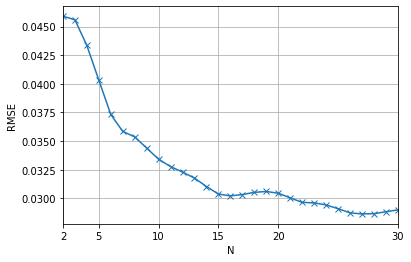

In [55]:
#plot to see which is the best N
plt.figure()
plt.plot(np.arange(2, 31), cv_rmse_list, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])
plt.xticks([2, 5, 10, 15, 20,30]);

In [58]:
# choose 30 as the best number of days
target_col = 'log_ret'
N = 27
offset = train_validation.shape[0]
y_pred = get_preds_rolling(df, target_col, N, pred_func, offset)
y_true = test[target_col].values
lin_reg_rmse = get_rmse(y_true, y_pred)
lin_reg_acc=up_or_down_acc(up_or_down(y_pred),up_or_down(y_true))
print('Results of linear regression prediction')
print('RMSE: %f' % lin_reg_rmse)
print('ACC: %f' % lin_reg_acc)

Results of linear regression prediction
RMSE: 0.022704
ACC: 0.471831


### 4.2.3 K Nearest Neighbour

* K nearest Neighbour: An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). 
* When predicting tomorrow's logarithmic return, we use the "average method", which uses the average of the logarithmic return corresponding to the k samples as the prediction result.

In [57]:
from sklearn.neighbors import KNeighborsRegressor
n_neighbors_list = [2, 5, 10, 20, 50, 100]
cv_rmse_list = [] 
for n_neighbors in n_neighbors_list:
    print('Number of neighbors: ', n_neighbors) 
    model = KNeighborsRegressor(n_neighbors) 
    model.fit(train_scaled[input_features], y_train) 
    y_pred = model.predict(cv_scaled[input_features])
    print(f'RMSE: {get_rmse(y_cv, y_pred)}')
    print(f'ACC: {up_or_down_acc(up_or_down(y_pred),up_or_down(y_cv))}')
    print()

Number of neighbors:  2
RMSE: 0.03302155680645315
ACC: 0.5140845070422535

Number of neighbors:  5
RMSE: 0.029497317077614722
ACC: 0.5070422535211268

Number of neighbors:  10
RMSE: 0.029192799517698827
ACC: 0.5070422535211268

Number of neighbors:  20
RMSE: 0.02835261200463525
ACC: 0.5

Number of neighbors:  50
RMSE: 0.027745251524630893
ACC: 0.5

Number of neighbors:  100
RMSE: 0.027623709109903416
ACC: 0.5



In [59]:
#use 100 as KNeighborsRegressor for getting the lowest RMSE
model = KNeighborsRegressor(n_neighbors=100)
model.fit(train_cv_scaled[input_features], y_train_cv) 
y_pred = model.predict(test_scaled[input_features])
knn_basic_rmse = get_rmse(y_test, y_pred)

print('Results of knn regression prediction on basic input features')
print('RMSE: %f' % knn_basic_rmse)


Results of knn regression prediction on basic input features
RMSE: 0.020609


In [62]:
#use 2 as KNeigborsRegressor for getting the highest acc
model = KNeighborsRegressor(n_neighbors=100)
model.fit(train_cv_scaled[input_features], y_train_cv) 
y_pred = model.predict(test_scaled[input_features])
knn_basic_acc=up_or_down_acc(up_or_down(y_pred),up_or_down(y_true))
print('ACC: %f' % knn_basic_acc)


ACC: 0.556338


In [63]:
#include technical indicators
n_neighbors_list = [2, 5, 10, 20, 50, 100] 
cv_rmse_list = [] 
for n_neighbors in n_neighbors_list:
    print('Number of neighbors: ', n_neighbors)
    model = KNeighborsRegressor(n_neighbors)
    model.fit(train_scaled, y_train)
    y_pred = model.predict(cv_scaled)
    print(get_rmse(y_cv, y_pred))
    print(up_or_down_acc(up_or_down(y_pred),up_or_down(y_cv)))

Number of neighbors:  2
0.03297445668727612
0.5211267605633803
Number of neighbors:  5
0.029387891387453444
0.5140845070422535
Number of neighbors:  10
0.02910165102554865
0.5070422535211268
Number of neighbors:  20
0.028344086842419965
0.5
Number of neighbors:  50
0.027741396811870263
0.5
Number of neighbors:  100
0.027624115505630212
0.5


In [60]:
#use 100 as KNeighborsRegressor for getting the lowest RMSE
model = KNeighborsRegressor(n_neighbors=100)
model.fit(train_cv_scaled, y_train_cv)
y_pred = model.predict(test_scaled)
knn_rmse = get_rmse(y_test, y_pred)

print('Results of knn regression prediction')
print('RMSE: %f' % knn_rmse)


Results of knn regression prediction
RMSE: 0.020615


In [61]:
#use 5 as KNeigborsRegressor for getting the highest acc
model = KNeighborsRegressor(n_neighbors=5)
model.fit(train_cv_scaled, y_train_cv)
y_pred = model.predict(test_scaled)
knn_acc=up_or_down_acc(up_or_down(y_pred),up_or_down(y_true))
print('ACC: %f' % knn_acc)


ACC: 0.521127


### 4.2.4 Random Forest

* Random forests: an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

In [63]:
params = {'max_depth': [2, 3, 4, 5], 'n_estimators': [10, 50, 100]}

for param in list(ParameterGrid(params)):
    print('Params: ', param)
    model = RandomForestRegressor(**param, random_state=0)
    model.fit(train_scaled, y_train) 
    y_pred = model.predict(cv_scaled)
    print(f'RMSE:{get_rmse(y_cv, y_pred)}')
    print(f'ACC: {up_or_down_acc(up_or_down(y_pred),up_or_down(y_cv))}')
    print()

Params:  {'max_depth': 2, 'n_estimators': 10}
RMSE:0.02762431816987821
ACC: 0.5

Params:  {'max_depth': 2, 'n_estimators': 50}
RMSE:0.027621730485352426
ACC: 0.5

Params:  {'max_depth': 2, 'n_estimators': 100}
RMSE:0.027624084497358672
ACC: 0.5

Params:  {'max_depth': 3, 'n_estimators': 10}
RMSE:0.027644742913528992
ACC: 0.5

Params:  {'max_depth': 3, 'n_estimators': 50}
RMSE:0.027622425745596316
ACC: 0.5

Params:  {'max_depth': 3, 'n_estimators': 100}
RMSE:0.02762112036854598
ACC: 0.5

Params:  {'max_depth': 4, 'n_estimators': 10}
RMSE:0.027683719037611788
ACC: 0.5

Params:  {'max_depth': 4, 'n_estimators': 50}
RMSE:0.02766728556091874
ACC: 0.5

Params:  {'max_depth': 4, 'n_estimators': 100}
RMSE:0.027645877610878312
ACC: 0.5

Params:  {'max_depth': 5, 'n_estimators': 10}
RMSE:0.027744418414257944
ACC: 0.5

Params:  {'max_depth': 5, 'n_estimators': 50}
RMSE:0.027696875005506254
ACC: 0.5

Params:  {'max_depth': 5, 'n_estimators': 100}
RMSE:0.027633674408669737
ACC: 0.5



In [64]:
model = RandomForestRegressor(max_depth=3, n_estimators=10) 
model.fit(train_cv_scaled, y_train_cv)
y_pred = model.predict(test_scaled) 
rf_rmse = get_rmse(y_test, y_pred)
rf_acc=up_or_down_acc(up_or_down(y_pred),up_or_down(y_true))
print('ACC: %f' % rf_acc)
print('Results of random forest regression prediction')
print('RMSE: %f' % rf_rmse)

ACC: 0.521127
Results of random forest regression prediction
RMSE: 0.020917


* In machine learning part, we use linear regression, K nearest neighbors and random forest to predict the logarithm of the closing price of the next day. We can see that random forest is the best, for its accuracy is the highest. And the accuracy in random forest is better than it in ARIMA.

## 4.3 Deep Learning

In [65]:
df, train, cv, train_cv, test = split_data(stock_df)
print('Train dataset shape: %s' % str(train.shape))
print('Validation dataset shape: %s' % str(cv.shape))
print('Test dataset shape: %s' % str(test.shape))

Train dataset shape: (1693, 21)
Validation dataset shape: (142, 21)
Test dataset shape: (142, 21)


In [66]:
train_data = train[['log_ret']]
cv_data = cv[['log_ret']]
train_cv_data = train_cv[['log_ret']]
test_data = test[['log_ret']]

In [67]:
#The data is normalized by z-score
# The train set is normalized based on the mean and variance of the training set
from sklearn.preprocessing import StandardScaler
train_scaler = StandardScaler()
train_data_scaled = train_scaler.fit_transform(train_data).reshape(-1, 1)
cv_data_scaled = train_scaler.transform(cv_data).reshape(-1, 1)
# The test set is normalized based on the mean and variance of the training set and the validation set
train_cv_scaler = StandardScaler()
train_cv_data_scaled = train_cv_scaler.fit_transform(
    train_cv_data).reshape(-1, 1)
test_data_scaled = train_cv_scaler.transform(test_data).reshape(-1, 1)

In [68]:
#Extraction of input features and prediction targets
def get_x_y(data, N, offset):
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i - N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)

    return x, y

In [69]:
#We use the log return of the previous N days as the input feature:
N = 9
# The reason why offset=N here is that the first few days do not have the log return of the previous N days, so the input feature is insufficient
x_train_scaled, y_train_scaled = get_x_y(train_data_scaled, N, N)
y_train = train_data[N:]
# To obtain the input features of the validation set, we need to spliced the part of the training set, and then only take the part of the validation set when obtaining the results
x_cv_scaled, y_cv_scaled = get_x_y(np.concatenate(
    (train_data_scaled, cv_data_scaled), axis=0), N, len(train_data_scaled))
y_cv = cv_data[:]
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_data_scaled, N, N)
y_train_cv = train_cv_data[N:]
# To obtain the input features of the test set, we need to spliced the part of the training set and the validation set, and then only take the part of the test set when obtaining the results
x_test_scaled, y_test_scaled = get_x_y(np.concatenate(
    (train_cv_data_scaled, test_data_scaled), axis=0), N, len(train_cv_data_scaled))
y_test = test_data[:]

### 4.3.1 MLP

* A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

Using TensorFlow backend.


In [71]:
mlp_units = 50  # The number of neurons in each layer
dropout_prob = 0.1  # The probability of dropout
optimizer = 'adam'  # The optimizer
epochs = 10  # Number of training cycles
batch_size = 8  # The number of small samples used for each update parameter
activation = 'relu'  # The activation function

In [72]:
model = Sequential()
# A Dense is a fully connected layer, and the shape of the input is determined by the dimensions of our input data (number of samples, 9 days, number of features per day)
# The later layers automatically determine the shape of the input and output
model.add(Dense(units=mlp_units, activation=activation, input_shape=(x_train_scaled.shape[1:])))
model.add(Dropout(dropout_prob))
# Flatten flattens out the input at the upper level
model.add(Flatten())
model.add(Dense(units=mlp_units, activation=activation))
model.add(Dropout(dropout_prob))
model.add(Dense(1, activation=activation))

model.compile(loss='mean_squared_error', optimizer=optimizer)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9, 50)             100       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 450)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                22550     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 22,701
Trainable params: 22,701
Non-trainable params: 0
__________________________________________________

In [77]:
model.fit(x_train_scaled, y_train_scaled, epochs=epochs,
          batch_size=batch_size, verbose=2)

Epoch 1/10
 - 0s - loss: 1.0059
Epoch 2/10
 - 0s - loss: 1.0032
Epoch 3/10
 - 0s - loss: 1.0032
Epoch 4/10
 - 0s - loss: 1.0032
Epoch 5/10
 - 0s - loss: 1.0032
Epoch 6/10
 - 0s - loss: 1.0032
Epoch 7/10
 - 0s - loss: 1.0032
Epoch 8/10
 - 0s - loss: 1.0032
Epoch 9/10
 - 0s - loss: 1.0032
Epoch 10/10
 - 0s - loss: 1.0032


In [78]:
y_cv_pred = model.predict(x_cv_scaled)
y_cv_pred = train_scaler.inverse_transform(y_cv_pred)
print(get_rmse(y_cv, y_cv_pred))
print(up_or_down_acc(up_or_down(y_pred),up_or_down(y_true)))

0.027620107283524906
0.5140845070422535


In [79]:
model.fit(x_train_cv_scaled, y_train_cv_scaled, epochs=epochs,
          batch_size=batch_size, verbose=2)

Epoch 1/10
 - 0s - loss: 1.0029
Epoch 2/10
 - 0s - loss: 1.0029
Epoch 3/10
 - 0s - loss: 1.0029
Epoch 4/10
 - 0s - loss: 1.0029
Epoch 5/10
 - 0s - loss: 1.0029
Epoch 6/10
 - 0s - loss: 1.0029
Epoch 7/10
 - 0s - loss: 1.0029
Epoch 8/10
 - 0s - loss: 1.0029
Epoch 9/10
 - 0s - loss: 1.0029
Epoch 10/10
 - 0s - loss: 1.0029


In [80]:
y_test_pred = model.predict(x_test_scaled)
y_test_pred = train_cv_scaler.inverse_transform(y_test_pred)
print(get_rmse(y_test, y_test_pred))
print(up_or_down_acc(up_or_down(y_pred),up_or_down(y_true)))

0.020847346840091176
0.5140845070422535


### 4.3.2 LSTM

* Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture.Unlike standard feedforward neural networks, LSTM has feedback connections. 

In [81]:
lstm_units = 50
dropout_prob = 0.1
optimizer = 'adam'
epochs = 10
batch_size = 8
activation = 'tanh'

In [82]:
from keras.layers import LSTM

model = Sequential()
# The reason return_sequences=True is because we will use a layer of LSTM structure later
model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True,
               input_shape=x_train_scaled.shape[1:]))
model.add(Dropout(dropout_prob))
model.add(LSTM(units=lstm_units, activation=activation))
model.add(Dropout(dropout_prob))
model.add(Dense(1, activation=activation))

model.compile(loss='mean_squared_error', optimizer=optimizer)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
model.fit(x_train_scaled, y_train_scaled, epochs=epochs,
          batch_size=batch_size, verbose=2)

Epoch 1/10
 - 2s - loss: 1.0070
Epoch 2/10
 - 1s - loss: 1.0044
Epoch 3/10
 - 1s - loss: 1.0031
Epoch 4/10
 - 1s - loss: 1.0051
Epoch 5/10
 - 1s - loss: 1.0045
Epoch 6/10
 - 1s - loss: 1.0035
Epoch 7/10
 - 1s - loss: 1.0037
Epoch 8/10
 - 1s - loss: 1.0038
Epoch 9/10
 - 1s - loss: 1.0014
Epoch 10/10
 - 1s - loss: 0.9998


In [84]:
y_cv_pred = model.predict(x_cv_scaled)
y_cv_pred = train_scaler.inverse_transform(y_cv_pred)
print(get_rmse(y_cv, y_cv_pred))

0.027414322799745133


In [85]:
model.fit(x_train_cv_scaled, y_train_cv_scaled, epochs=epochs,
          batch_size=batch_size, verbose=2)

Epoch 1/10
 - 1s - loss: 0.9988
Epoch 2/10
 - 1s - loss: 0.9961
Epoch 3/10
 - 1s - loss: 0.9964
Epoch 4/10
 - 1s - loss: 0.9973
Epoch 5/10
 - 1s - loss: 0.9949
Epoch 6/10
 - 1s - loss: 0.9952
Epoch 7/10
 - 1s - loss: 0.9936
Epoch 8/10
 - 1s - loss: 0.9912
Epoch 9/10
 - 1s - loss: 0.9914
Epoch 10/10
 - 1s - loss: 0.9873


In [86]:
y_test_pred = model.predict(x_test_scaled)
y_test_pred = train_cv_scaler.inverse_transform(y_test_pred)
print(get_rmse(y_test, y_test_pred))
print(up_or_down_acc(up_or_down(y_pred),up_or_down(y_true)))

0.02082072678396068
0.5140845070422535


* In this deep learning part, we use LMP and LSTM to predict the logarithm of the closing price of the next day. We can see that LMP is the best. It's even better than random forest.

## 5.Predict Up and Down (Classification purely)

### 5.1 Baseline Model

In [73]:
train = lagged_df['2010-01-01':'2017-12-31']
cv = lagged_df['2018-01-01': '2018-12-31']
train_cv = lagged_df['2010-01-01':'2018-12-31']
test = lagged_df['2019-01-01': '2019-12-31']

In [74]:
y_train_clf = [1 if i > 0 else 0 for i in train[target_col]]
y_cv_clf = [1 if i > 0 else 0 for i in cv[target_col]]
y_train_cv_clf = [1 if i > 0 else 0 for i in train_cv[target_col]]
y_test_clf = [1 if i > 0 else 0 for i in test[target_col]]

In [75]:
from sklearn.metrics import accuracy_score 
def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [76]:
print('Always up: ', sum(y_train_cv_clf) / len(y_train_cv_clf))
print('Always down: ', 1 - sum(y_train_cv_clf) / len(y_train_cv_clf))

Always up:  0.4997269251774986
Always down:  0.5002730748225014


* We use always down as our baseline model.

### 5.2 KNN

In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [78]:
n_neighbors_list = [2, 5, 8,9,10,12, 13,14,15,16,17,18,19,20]
cv_rmse_list = []
for n_neighbors in n_neighbors_list:
    print('Number of neighbors: ', n_neighbors)
    model = KNeighborsClassifier(n_neighbors)
    model.fit(train_scaled, y_train_clf)
    y_pred_clf = model.predict(cv_scaled)
    print(get_accuracy(y_cv_clf, y_pred_clf))
    


Number of neighbors:  2
0.5140845070422535
Number of neighbors:  5
0.5422535211267606
Number of neighbors:  8
0.5
Number of neighbors:  9
0.5211267605633803
Number of neighbors:  10
0.5070422535211268
Number of neighbors:  12
0.5070422535211268
Number of neighbors:  13
0.5140845070422535
Number of neighbors:  14
0.5070422535211268
Number of neighbors:  15
0.5140845070422535
Number of neighbors:  16
0.5070422535211268
Number of neighbors:  17
0.5070422535211268
Number of neighbors:  18
0.5
Number of neighbors:  19
0.5
Number of neighbors:  20
0.5


In [79]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_cv_scaled, y_train_cv_clf) 
y_pred_clf = model.predict(test_scaled) 
knn_accu = get_accuracy(y_test_clf, y_pred_clf)
print('Results of knn classifier prediction')
print('Accuracy: %f' % knn_accu)

Results of knn classifier prediction
Accuracy: 0.521127


### 5.3 SVM

* In machine learning, support-vector machines (SVMs, also support-vector networks[1]) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. 

In [81]:
from sklearn.svm import SVC
c_list = [1, 2, 5, 10,11,12,13,14,15]
cv_rmse_list = []
for c in c_list:
    print('C: ', c)
    model = SVC(c, random_state=0)
    model.fit(train_scaled, y_train_clf)
    y_pred_clf = model.predict(cv_scaled)
    print(get_accuracy(y_cv_clf, y_pred_clf))

C:  1
0.5
C:  2
0.5
C:  5
0.5
C:  10
0.5
C:  11
0.5
C:  12
0.5
C:  13
0.5
C:  14
0.5
C:  15
0.5


In [82]:
model = SVC(C=1, random_state=0)
model.fit(train_cv_scaled, y_train_cv_clf)
y_pred_clf = model.predict(test_scaled)
svc_accu = get_accuracy(y_test_clf, y_pred_clf)
print('Results of svc classifier prediction')
print('Accuracy: %f' % svc_accu)

Results of svc classifier prediction
Accuracy: 0.563380


## 6. Analysis Evaluation and Trade Simulation

### 6.1 Function to Proceed with

### Winrate Calculation

* A win is when the direction of the trading signal (+1 or -1) is consistant with the direction of the closing price from Day 2 to Day 3.

In [96]:
def cal_winrate(df, signal_col, ret_col):
    win = df.loc[(df[signal_col] * df[ret_col]) > 0, 'log_ret']
    loss = -df.loc[(df[signal_col] * df[ret_col]) < 0, 'log_ret']
    total = len(win) + len(loss)
    winrate = len(win)/total
    return winrate, win, loss

### Trade Simulation

* We designed a simple simulation to evaluate different trading signals. The initial cash is $200,000 and we're just going to trade 100 shares, whether we're going to buy or sell and regardless of the transaction fee. At the beginning, we only had cash. When there was an opportunity to build a position, which means the time when the price rose for two days in a row and the trading signal did not show selling, we need to open an account to hold the stock. Sell 100 shares when yesterday's trading signal indicates selling and the number of shares held is more than 0; When yesterday's trading signal shows buying and hold enough cash, buy 100 shares at the day's closing price.


* We will evaluate the changes in the assets corresponding to the different trading strategies, which is the sum of the cash and the value of the stocks that we own. And then we're going to evaluate the return on the asset, which is the asset at the end of the evaluation period versus the $200,000 that we started with, whether we made a profit or a loss; We will also look at the lowest retracement rate, which is the total assets lost over hardest time.

In [97]:
def trade_sim(df, signal_col, close_col):
    signal = df[signal_col]
    close = df[close_col]
    cash = pd.Series(0.0, index=df.index)
    asset = pd.Series(0.0, index=df.index)
    share = pd.Series(0.0, index=df.index)
    trade_signal = signal.shift(1)
    trade_unit = 100
    entry = 3
    cash[:entry] = 200000
    while entry < len(close):
        cash[entry] = cash[entry-1]
        if close[entry-1] >= close[entry-2] and close[entry-2] >= close[entry-3] and signal[entry-1] != -1:
            share[entry] = trade_unit
            cash[entry] = cash[entry] - trade_unit * close[entry]
            break
        entry += 1
    i = entry + 1
    while i < len(trade_signal):
        cash[i] = cash[i - 1]
        share[i] = share[i - 1]
        if trade_signal[i] == 1:
            if cash[i] >= trade_unit * close[i]:
                share[i] = share[i] + trade_unit
                cash[i] = cash[i] - trade_unit * close[i]
        if trade_signal[i] == -1:
            if share[i] >= trade_unit:
                share[i] = share[i] - trade_unit
                cash[i] = cash[i] + trade_unit * close[i]
        i+=1
    asset = cash + share * close 
    return cash, share, asset

### Max Drawdown and Asset Return Ratio

In [98]:
#calculate max_drawdown
def max_drawdown_slow(X):
    drawdown_max=0
    for i in range(len(X)):
        for j in range(i, len(X)):
            drawdown=(X[i] - X[j])/X[i]
            drawdown_max=max(drawdown_max, drawdown) 
    return drawdown_max * 100

def max_drawdown(X):
    i = np.argmax((np.maximum.accumulate(X) - X)/np.maximum.accumulate(X)) # end of the period 
    j = np.argmax(X[:i]) # start of period 
    return (1-X[i]/X[j]) * 100

#calculate asset return ratio
def asset_evaluate(asset):
    ret_ratio = (asset[-1] - 200000) / 200000 * 100 
    maxdd = max_drawdown(asset) 
    return maxdd, ret_ratio

### 6.2 Trade Signal based on Momentum

* Momentum effect refers to that when the stock price rises, it may have the momentum to continue to rise. When a stock price falls, it may have momentum to fall further.
* The basic idea of designing trading signals based on momentum indicators is as follows: when momentum is positive on the 35th day, there may still be rising energy in the market. We recommend that the second phase can conduct buying. When the momentum is negative on the 35th day, we expect that the price may fall in the future, and the 2nd phase can be operated as selling.

In [99]:
def momentum_signal(df, timeperiod=35):
    df['mom35'] = talib.MOM(df['Close'], timeperiod=timeperiod)
    df.fillna(0, inplace=True)
    df['mom_signal'] = 0 
    #if the momentum for 35 days is greater than 0 ,output signal as 1 for buying
    df.loc[df['mom35'] > 0, 'mom_signal'] = 1
    #if the momentum for 35 days is less than 0 ,output signal as -1 for buying
    df.loc[df['mom35'] < 0, 'mom_signal'] = -1
    return df

df = momentum_signal(df)

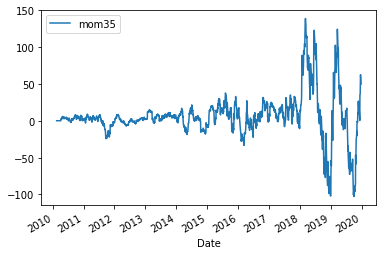

In [100]:
df[['mom35']].plot();

In [101]:
#summary the signals for buy and sell
print(df.loc[df['mom_signal'] == 1, :].shape)
print(df.loc[df['mom_signal'] == -1, :].shape)

(1338, 23)
(604, 23)


In [102]:
winrate_netflix, win_netflix, loss_netflix = cal_winrate(df, 'mom_signal', 'log_ret')
print(winrate_netflix)

0.49432404540763675


In [103]:
#evaluate asset changes based on momentum signal
cash_netflix_mom, share_netflix_mom, asset_netflix_mom = trade_sim(df, 'mom_signal', 'Close')

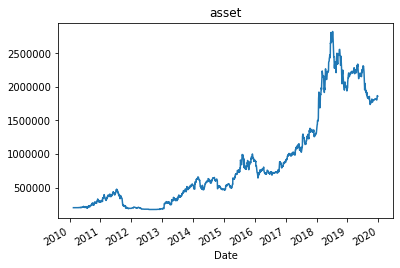

In [104]:
asset_netflix_mom.plot(title='asset');

* The winning rate is 0.5. However, assets fluctuate greatly, but the assets increase a lot. There are no big gains or losses on assets.

### 6.3 Trade signal based on RSI signal

* For the relative strength index (RSI), when the short-term RSI line crosses the long-term RSI line upward, the recent buying signal of stocks is strong, and the impetus for price rise is strong, which releases a strong buying signal. It is known as "golden cross". However, when the short-term RSI line drops below the long-term RSI line, the recent selling force of stocks is strong, and the price decline trend is strong, which releases a strong sell signal. It is known as "death cross".
* The basic idea of trading signal design based on relative strength index is as follows: 
* Calculate the values of RSI6 and RSI24; 
* When RSI6>80 or RSI6 goes down through RSI24, it is a sell signal. 
* When RSI6 < 20 or upward through the RSI24 RSI6, it is a buy signal.

In [105]:
def rsi_signal(df, timeperiod_short=6, timeperiod_long=24):
    # The default calculations are rsi6 and rsi24
    df['rsi6'] = talib.RSI(df['Close'], timeperiod=timeperiod_short)
    df['rsi24'] = talib.RSI(df['Close'], timeperiod=timeperiod_long)
    df.fillna(0, inplace=True)
    df['rsi_signal'] = 0
    # RSI6<20：buy
    df.loc[df['rsi6'] < 20, 'rsi_signal'] = 1
    # RSI6>80: sell
    df.loc[df['rsi6'] > 80, 'rsi_signal'] = -1

    # Get rsi6 and rsi24 from 1 day ago
    df['lagrsi6'] = df['rsi6'].shift(1)
    df['lagrsi24'] = df['rsi24'].shift(1)
    # rsi6 up cross rsi24, gold cross, buy
    df.loc[(df['rsi6'] > df['rsi24']) & (df['lagrsi6'] < df['lagrsi24']), 'rsi_signal'] = 1
    # rsi6 down cross rsi24，death cross，sell
    df.loc[(df['rsi6'] < df['rsi24']) & (df['lagrsi6'] > df['lagrsi24']), 'rsi_signal'] = -1
    # we don't need lagrsi6， lagrsi24 anymore
    df = df.drop(columns=['lagrsi6', 'lagrsi24'])
    return df

df_netflix = rsi_signal(df)

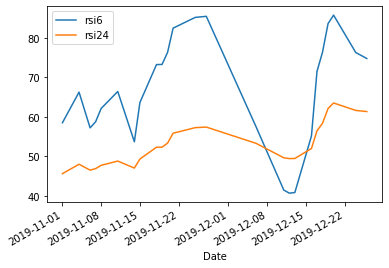

In [106]:
df_netflix.tail(25)[['rsi6', 'rsi24']].plot()

In [107]:
print(df_netflix.loc[df_netflix['rsi_signal'] == 1, :].shape)
print(df_netflix.loc[df_netflix['rsi_signal'] == -1, :].shape)

(250, 26)
(403, 26)


In [108]:
winrate_netflix, win_netflix, loss_netflix = cal_winrate(df_netflix, 'rsi_signal', 'log_ret')
print(winrate_netflix)

0.5414110429447853


In [109]:
cash_netflix_rsi, share_netflix_rsi, asset_netflix_rsi = trade_sim(df_netflix, 'rsi_signal', 'Close')

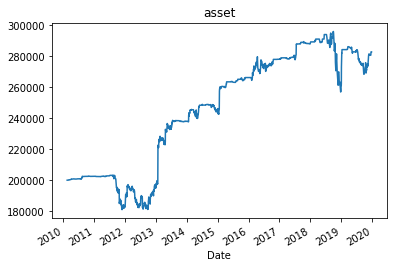

In [110]:
asset_netflix_rsi.plot(title='asset');

* The winning rate is 0.47, less than it in trade based on momentum signal. However, the general trend of assets is increasing.

### 6.4 Trade Signal Based on Candlestick Chart

* The basic idea of Double Moving Average Crossover is to identify the change of price trend by using the relative relationship of long and short moving average. 
* The basic ideas of trading signal design are as follows: 
* Find the short - term average and long - term average; 
* When a short-term moving average crosses a long-term moving average from the bottom up, it releases a buy signal; 
* When a short - term moving average crosses a long - term moving average from the top down, it releases a sell - off signal.

In [111]:
def ma_signal(df, timeperiod_short=5, timeperiod_long=30):
    # Ma5 and ma30 are computed by default
    df['ma5'] = talib.MA(df['Close'], timeperiod=timeperiod_short)
    df['ma30'] = talib.MA(df['Close'], timeperiod=timeperiod_long)
    df.fillna(0, inplace=True)
    df['ma_signal'] = 0

    # Get ma5 and ma30 from 1 day ago
    df['lagma5'] = df['ma5'].shift(1)
    df['lagma30'] = df['ma30'].shift(1)
    # Ma5 up through ma30, buy
    df.loc[(df['ma5'] > df['ma30']) & (df['lagma5'] < df['lagma30']), 'ma_signal'] = 1
    # Ma5 goes down to ma30 , sells
    df.loc[(df['ma5'] < df['ma30']) & (df['lagma5'] > df['lagma30']), 'ma_signal'] = -1
    # We don't need lagma5,lagma30 anymore
    df = df.drop(columns=['lagma5', 'lagma30'])
    return df

df_netflix = ma_signal(df)

In [112]:
print(df_netflix.loc[df_netflix['ma_signal'] == 1, :].shape)
print(df_netflix.loc[df_netflix['ma_signal'] == -1, :].shape)

(38, 31)
(38, 31)


In [113]:
winrate_netflix, win_netflix, loss_netflix = cal_winrate(df, 'ma_signal', 'log_ret')
print(winrate_netflix)

0.5526315789473685


In [114]:
cash_netflix_ma, share_netflix_ma, asset_netflix_ma = trade_sim(df_netflix, 'ma_signal', 'Close')

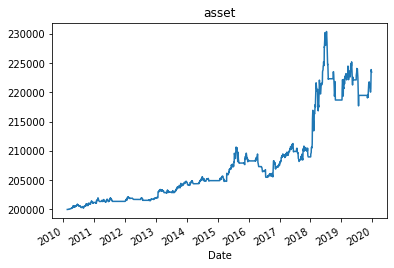

In [115]:
asset_netflix_ma.plot(title='asset')

* The winning rate is 0.52, but the assets rise and fall without big changes.

### 6.5 Trade Signal  Based on Bollinger Bands

* The most common strategy of bollinger bands is to make a trading strategy by breaking the upper and lower bounds according to the price line. 
* The basic idea of designing trading signals is as follows:
* When the stock price goes up through the band, the stock may have an abnormal rise, and the stock price will fall into the band in the future. We should go short.
* When the stock price goes down through the band, the stock may have an abnormal decline, the future price will rise to the inside of the band. We should go long.

In [116]:
def bollinger_signal(df):
    # use 
    df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Close'], nbdevup=1, nbdevdn=1, timeperiod=5)
    df.fillna(0, inplace=True)
    df['bollinger_signal'] = 0
    #get the previous day's close data, upperband and lowerband
    df['lagclose'] = df['Close'].shift(1)
    df['lagupperband'] = df['upperband'].shift(1)
    df['laglowerband'] = df['lowerband'].shift(1)
    # close is lower than the lowerband，output the signal as buy
    df.loc[(df['Close'] < df['lowerband']) & (df['lagclose'] > df['laglowerband']), 'bollinger_signal'] = 1
    # close is higher than the lowerband，output the signal as sell
    df.loc[(df['Close'] > df['upperband']) & (df['lagclose'] < df['lagupperband']), 'bollinger_signal'] = -1
    df = df.drop(columns=['lagclose', 'lagupperband', 'laglowerband'])
    return df

df_netflix= bollinger_signal(df)

In [117]:
print(df_netflix.loc[df_netflix['bollinger_signal'] == 1, :].shape)
print(df_netflix.loc[df_netflix['bollinger_signal'] == -1, :].shape)

(225, 37)
(288, 37)


In [118]:
winrate_netflix, win_netflix, loss_netflix = cal_winrate(df_netflix, 'bollinger_signal', 'log_ret')
print(winrate_netflix)

0.5165692007797271


In [119]:
cash_netflix_bollinger, share_netflix_bollinger, asset_netflix_bollinger = trade_sim(df_netflix, 'bollinger_signal', 'Close')


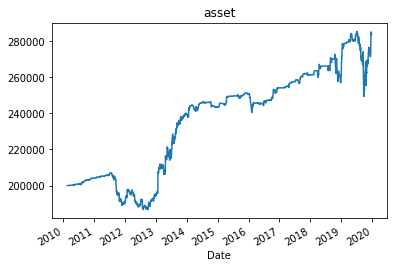

In [120]:
asset_netflix_bollinger.plot(title='asset');

* The winning rate is 0.51. The assets are increasing. The increasing pace is slower than it in in trade based on RSI signal.

### 6.6 Trade Signals Comparison

In [121]:
#evaluate the Max Drawdown and Return Ratio 
asset_result = {}
mom_maxdd, mom_ret_ratio = asset_evaluate(asset_netflix_mom)
rsi_maxdd, rsi_ret_ratio = asset_evaluate(asset_netflix_rsi)
ma_maxdd, ma_ret_ratio = asset_evaluate(asset_netflix_ma)
bollinger_maxdd, bollinger_ret_ratio = asset_evaluate(asset_netflix_bollinger)

asset_result = {'maxdd': [mom_maxdd, rsi_maxdd, ma_maxdd, bollinger_maxdd], 'ret_ratio': [mom_ret_ratio, rsi_ret_ratio, ma_ret_ratio, bollinger_ret_ratio]} 
asset_result_df = pd.DataFrame(asset_result, index=['mom', 'rsi', 'ma', 'bollinger'])
print(asset_result_df)

               maxdd   ret_ratio
mom        63.741117  828.915567
rsi        13.199292   41.433718
ma          5.504906   11.719072
bollinger  12.579066   41.871429


* If you are a investor with low risk tolerance, trading strategy based on RSI signals is best for you. Trading stategy based on RSI signals performed best on our historical data from Pfizer, achieving the relatively high return (10.18%) on a relatively small drawdown(3.12%).
* If you are a investor with high risk tolerance, trading strategy based on momentum signals are best for you. Trading stategies based on momentum signals performed best on our historical data from Pfizer, achieving the highest return (49.74%) on a relatively high drawdown(22.31%).